Found 352 images belonging to 1 classes.


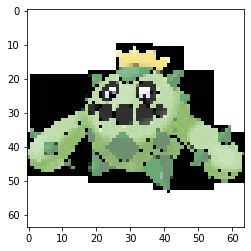

In [5]:
#In this notebook, you'll learn how to implement a Generative Adversarial Network (GAN).
#The goal of a GAN is to create one network - a "Generator" - which seeks to create pictures
#of something (in our case - pokemon); the second network is a "Discriminator", which examines
#our generated pictures and tries to determine if they are fake or real.
#The generator network learns over multiple iterations to "fool" the discriminator - 
#hopefully creating some powerful pokemon!
#Note GANs are data hungry, so I'm combining gen1 and gen2 pokemon.  Blasphemy, I know.

#(Also Note - Pokemon are a very popular starting point for GAN.  For all sorts of implementations, 
#search for "PokeGAN").

import keras
import pandas as pd
import tensorflow_hub as hub
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

#We're going to implement our GAN as a class, mostly so as to keep our sanity!

class GAN:
    def __init__(self):
        self.dataFolder = "./pocketMonsters"
        self.targetShape = (64, 64, 3)
        self.batchSize = 64
        self.epochs = 100

    #Note in our data generator, we're not doing any image augmentation.
    #You could, but you would want to limit yourself to generators that
    #retain the look, feel, heart and soul of pocketmonsters.
    def loadData(self):
        dataset_generator = keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
            self.dataFolder, target_size=(self.targetShape[0], self.targetShape[1]),
            batch_size=self.batchSize,
            class_mode=None)

        return dataset_generator

pokeGAN = GAN()

train = pokeGAN.loadData()                                    

plt.imshow(next(train)[10].astype('uint8'))
plt.show()
    

In [6]:
class GAN:
    def __init__(self):
        self.dataFolder = "./pocketMonsters"
        self.targetShape = (64, 64, 3)
        self.batchSize = 64
        self.epochs = 100

    def loadData(self):
        dataset_generator = ImageDataGenerator().flow_from_directory(
            self.dataFolder, target_size=(self.targetShape[0], self.targetShape[1]),
            batch_size=self.batchSize,
            class_mode=None)

        return dataset_generator

    #Next up: our descrimanator!  The basic idea of the GAN is to have a model
    #that checks if an image is real, and train another model (the generator)
    #on that model.  Here, we're creating the descriminator - i.e., the model
    #that checks if something is real or not.
    #For now we're just going to define it here - in a few cells, we'll take a look at how
    #we train it.
    def loadDescriminator(self):
        discriminator = keras.models.Sequential()
        discriminator.add(keras.layers.Conv2D(filters=64, kernel_size=(5, 5),
                                    strides=(2, 2), padding='same',
                                    data_format='channels_last',
                                    kernel_initializer='glorot_uniform',
                                    input_shape=self.targetShape))
        discriminator.add(keras.layers.LeakyReLU(0.2))

        discriminator.add(keras.layers.Conv2D(filters=128, kernel_size=(5, 5),
                                    strides=(2, 2), padding='same',
                                    data_format='channels_last',
                                    kernel_initializer='glorot_uniform'))
        discriminator.add(keras.layers.BatchNormalization(momentum=0.5))
        discriminator.add(keras.layers.LeakyReLU(0.2))

        discriminator.add(keras.layers.Conv2D(filters=256, kernel_size=(5, 5),
                                    strides=(2, 2), padding='same',
                                    data_format='channels_last',
                                    kernel_initializer='glorot_uniform'))
        discriminator.add(keras.layers.BatchNormalization(momentum=0.5))
        discriminator.add(keras.layers.LeakyReLU(0.2))

        discriminator.add(keras.layers.Conv2D(filters=512, kernel_size=(5, 5),
                                    strides=(2, 2), padding='same',
                                    data_format='channels_last',
                                    kernel_initializer='glorot_uniform'))
        discriminator.add(keras.layers.BatchNormalization(momentum=0.5))
        discriminator.add(keras.layers.LeakyReLU(0.2))

        discriminator.add(keras.layers.Flatten())
        discriminator.add(keras.layers.Dense(1))
        discriminator.add(keras.layers.Activation('sigmoid'))

        optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        discriminator.compile(loss='binary_crossentropy',
                                optimizer=optimizer,
                                metrics=None)

        return discriminator

pokeGAN = GAN()

model = pokeGAN.loadDescriminator() 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1

In [7]:
class GAN:
    def __init__(self):
        self.dataFolder = "./pocketMonsters"
        self.targetShape = (64, 64, 3)
        self.batchSize = 64
        self.epochs = 100

    #And, here is our generator.  This is a model that attempts
    #to create images that will fool the discriminator.
    #Again, we'll use this in a few cells to show how it works.
    #Of note is the input_shape for the first dense layer -
    #this is going to represent an input of random noise
    #that we're using to initialize the generator.
    def loadGenerator(self):
        generator = keras.models.Sequential()
        generator.add(keras.layers.Dense(units=4 * 4 * 512,
                            kernel_initializer='glorot_uniform',
                            input_shape=(1, 1, 100)))
        generator.add(keras.layers.Reshape(target_shape=(4, 4, 512)))
        generator.add(keras.layers.BatchNormalization(momentum=0.5))
        generator.add(keras.layers.Activation('relu'))

        generator.add(keras.layers.Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(keras.layers.BatchNormalization(momentum=0.5))
        generator.add(keras.layers.Activation('relu'))

        generator.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(keras.layers.BatchNormalization(momentum=0.5))
        generator.add(keras.layers.Activation('relu'))

        generator.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(keras.layers.BatchNormalization(momentum=0.5))
        generator.add(keras.layers.Activation('relu'))

        generator.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(keras.layers.Activation('tanh'))

        optimizer = keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
        generator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

        return generator

pokeGAN = GAN()

model = pokeGAN.loadGenerator() 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 1, 8192)        827392    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)        

In [8]:
class GAN:
    def __init__(self):
        self.dataFolder = "./pocketMonsters"
        self.targetShape = (64, 64, 3)
        self.batchSize = 64
        self.epochs = 100

    #Next up is a small helper function so we can see how the images evolve
    #across epochs:
    def saveImages(self, genImage, epochNum, batchNum):
            #We're generating 64 pokemon each iteration:
            plt.figure(figsize=(8, 8))
            grid = gridspec.GridSpec(8, 8)
            grid.update(wspace=0.1, hspace=0.1)

            for i in range(64):
                ax1 = plt.subplot(grid[i])
                ax1.set_aspect('equal')
                image = generated_images[i, :, :, :]

                #Scale colors between 1 and 255
                image += 1
                image *= 255
                fig = plt.imshow(image.astype(np.uint8))
                plt.axis('off')
                fig.axes.get_xaxis().set_visible(False)
                fig.axes.get_yaxis().set_visible(False)

            plt.tight_layout()
            save_name = 'myPokemon/epoch' + str(epoch_no + 1) + 'Batch' + str(batch_no + 1) + '.png'
            if not os.path.exists('myPokemon'):
                os.mkdir('myPokemon')
            plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
            plt.show()

In [9]:
class GAN:
    def __init__(self):
        self.dataFolder = "./pocketMonsters"
        self.targetShape = (64, 64, 3)
        self.batchSize = 64
        self.epochs = 100

    #Now we need to define how the generator and dicriminator
    #will interact, and how we'll optimize them.  This is 
    #the GAN itself.
    def loadGAN(self, generator, discriminator):
        m = keras.models.Sequential()
        discriminator.trainable = False
        m.add(generator)
        m.add(discriminator)

        optimizer = keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
        m.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=None)
        return m



In [20]:
#Finally, we add everything together into a mega-Class.
#The real heavy lifting is in the final method here - our training method!
#Running this cell will build our GAN.

import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import keras
import math
import IPython

class GAN:
    def __init__(self):
        self.dataFolder = "./pocketMonsters"
        self.targetShape = (64, 64, 3)
        self.batchSize = 64
        self.epochs = 100000

    #Note in our data generator, we're not doing any image augmentation.
    #You could, but you would want to limit yourself to generators that
    #retain the look, feel, heart and soul of pocketmonsters.
    def loadData(self):
        dataset_generator = keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
            self.dataFolder, target_size=(self.targetShape[0], self.targetShape[1]),
            batch_size=self.batchSize,
            class_mode=None)

        return dataset_generator

    def loadDiscriminator(self):
        discriminator = keras.models.Sequential()
        discriminator.add(keras.layers.Conv2D(filters=64, kernel_size=(5, 5),
                                    strides=(2, 2), padding='same',
                                    data_format='channels_last',
                                    kernel_initializer='glorot_uniform',
                                    input_shape=self.targetShape))
        discriminator.add(keras.layers.LeakyReLU(0.2))

        discriminator.add(keras.layers.Conv2D(filters=128, kernel_size=(5, 5),
                                    strides=(2, 2), padding='same',
                                    data_format='channels_last',
                                    kernel_initializer='glorot_uniform'))
        discriminator.add(keras.layers.BatchNormalization(momentum=0.5))
        discriminator.add(keras.layers.LeakyReLU(0.2))

        discriminator.add(keras.layers.Conv2D(filters=256, kernel_size=(5, 5),
                                    strides=(2, 2), padding='same',
                                    data_format='channels_last',
                                    kernel_initializer='glorot_uniform'))
        discriminator.add(keras.layers.BatchNormalization(momentum=0.5))
        discriminator.add(keras.layers.LeakyReLU(0.2))

        discriminator.add(keras.layers.Conv2D(filters=512, kernel_size=(5, 5),
                                    strides=(2, 2), padding='same',
                                    data_format='channels_last',
                                    kernel_initializer='glorot_uniform'))
        discriminator.add(keras.layers.BatchNormalization(momentum=0.5))
        discriminator.add(keras.layers.LeakyReLU(0.2))

        discriminator.add(keras.layers.Flatten())
        discriminator.add(keras.layers.Dense(1))
        discriminator.add(keras.layers.Activation('sigmoid'))

        optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        discriminator.compile(loss='binary_crossentropy',
                                optimizer=optimizer,
                                metrics=None)

        return discriminator

    def loadGenerator(self):
        generator = keras.models.Sequential()
        generator.add(keras.layers.Dense(units=4 * 4 * 512,
                            kernel_initializer='glorot_uniform',
                            input_shape=(1, 1, 100)))
        generator.add(keras.layers.Reshape(target_shape=(4, 4, 512)))
        generator.add(keras.layers.BatchNormalization(momentum=0.5))
        generator.add(keras.layers.Activation('relu'))

        generator.add(keras.layers.Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(keras.layers.BatchNormalization(momentum=0.5))
        generator.add(keras.layers.Activation('relu'))

        generator.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(keras.layers.BatchNormalization(momentum=0.5))
        generator.add(keras.layers.Activation('relu'))

        generator.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(keras.layers.BatchNormalization(momentum=0.5))
        generator.add(keras.layers.Activation('relu'))

        generator.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(keras.layers.Activation('tanh'))

        optimizer = keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
        generator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

        return generator

    def saveImages(self, genImage, epochNum):
            plt.figure(figsize=(8, 8))
            grid = gridspec.GridSpec(8, 8)
            grid.update(wspace=0.1, hspace=0.1)

            for i in range(64):
                ax1 = plt.subplot(grid[i])
                ax1.set_aspect('equal')
                image = genImage[i, :, :, :]

                image += 1
                image *= 127.5
                fig = plt.imshow(image.astype(np.uint8))
                plt.axis('off')
                fig.axes.get_xaxis().set_visible(False)
                fig.axes.get_yaxis().set_visible(False)

            #Small changes to this function for our run: we'll only save
            #once every five epochs for speed.
            save_name = 'myPokemon/epoch' + str(epochNum + 1) + '.png'
            if not os.path.exists('myPokemon'):
                os.mkdir('myPokemon')
            plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
            #We're commenting out this show for now, to let our script run faster.
            #We'll just save to a file.
            #plt.show()
            plt.close()

    def loadGAN(self, generator, discriminator):
        m = keras.models.Sequential()
        discriminator.trainable = False
        m.add(generator)
        m.add(discriminator)

        optimizer = keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
        m.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=None)
        return m


    def train(self):
        #Alright!  Now for the big payoff.
        #First, we load our three models - the generator,
        #discrimanator, and the GAN that strings the together.
        generator = self.loadGenerator()
        discriminator = self.loadDiscriminator()
        gan = self.loadGAN(generator, discriminator)

        # Load our pokemon data
        dataGenerator = self.loadData()
        
        #Calculate the number of batches per epoch required
        numBatches = math.ceil(dataGenerator.samples/self.batchSize)

        # Save our losses
        adversarialLoss = np.empty(shape=1)
        discriminatorLoss = np.empty(shape=1)
        batches = np.empty(shape=1)

        #Let's us show the outputs in Jupyter
        plt.ion()

        currentBatch = 0

        #Training loop starts here!
        for epoch in range(self.epochs):
            print("Epoch: " + str(epoch + 1) + " of " + str(self.epochs))
            for batchNum in range(numBatches):
                startTime = time.time()

                #First we load in this batch of real images:
                realPokemonImages = dataGenerator.next()

                #Here, we normalize to the color scale of the inpt pokemon 
                #(127.5), and then rescale to between -1 and 1.
                #
                realPokemonImages /= 127.5
                realPokemonImages -= 1

                #And calculate how many images we got:
                curBatchSize = realPokemonImages.shape[0]

                #Here, we generate noise to see our generator (remember the input of 100 on our generators Dense input!)
                noise = np.random.normal(0, 1, size=(curBatchSize,) + (1, 1, 100))

                #Make our new pokemon
                fakePokemonImages = generator.predict(noise)

                #We're going to update our discriminator, but don't want to tell it
                #exactly what is fake and what is real (as then it would train on our)
                #fake images, and we would never be able to fool it.
                #So, when we update we update with a "noisy" version of our Y, 
                #in which we randomly label a few true cases as fake,
                #and vice-versa.
                realPokemon_y = (np.ones(curBatchSize) - np.random.random_sample(curBatchSize) * 0.2)
                fakePokemon_y = np.random.random_sample(curBatchSize) * 0.2

                #This is where we update the Discriminator.
                #We don't allow it to be trained in the adverserial part of the GAN,
                #so we must manually do it here.
                discriminator.trainable = True

                #Here we train with both batches, and then save our loss and turn off
                #the discriminator training
                discLoss = discriminator.train_on_batch(realPokemonImages, realPokemon_y)
                discLoss += discriminator.train_on_batch(fakePokemonImages, fakePokemon_y)

                discriminatorLoss = np.append(discriminatorLoss, discLoss)
                discriminator.trainable = False


                #Now we are going to generate our pokemon!
                #Note here we're going to generate 64 "imaginary"
                #pokemon (i.e., those not living in Williamsburg)
                #This number is independent of your batch size - i.e.,
                #earlier in the training loop, we created 32 examples
                #to train our discriminator - this was so we had the same
                #number of real and fake cases.
                noise = np.random.normal(0, 1,size=(64,) + (1, 1, 100))

                #As before, we are going to assign a fraction of our fake cases to "true" cases
                #to see how well we can fool the discriminator
                fakePokemon_y = (np.ones(64) - np.random.random_sample(64) * 0.2)

                #Make the actual images
                fakePokemonImages = generator.predict(noise)

                gLoss = gan.train_on_batch(noise, fakePokemon_y)
                adversarialLoss = np.append(adversarialLoss, gLoss)
                batches = np.append(batches, currentBatch)                    
                
                timeElapsed = time.time() - startTime
                print("Epoch" + str(epoch) + " Batch " + str(batchNum + 1) + " of " + str(numBatches) + " | Generator Loss: " + str(round(gLoss, 3)) + " | Discriminator Loss: " + str(round(discLoss, 3)) + " | Time: " + str(timeElapsed) + " seconds.")


                currentBatch += 1

            # Regularly save model weights and images
            if (epoch + 1) % 5 == 0:
                discriminator.trainable = True
                if not os.path.exists('models'):
                    os.mkdir('models')
                generator.save('models/genEpoch' + str(epoch) + '.hdf5')
                discriminator.save('models/discEpoch' + str(epoch) + '.hdf5')
                self.saveImages(fakePokemonImages, epoch)

            # Update our loss graph
            plt.figure(1)
            plt.plot(batches, adversarialLoss, color='green',
                     label='Generator Loss')
            plt.plot(batches, discriminatorLoss, color='blue',
                     label='Discriminator Loss')
            plt.title("GAN Training")
            plt.xlabel("Batch Iteration")
            plt.ylabel("Loss")
            if epoch == 0:
                plt.legend()
            plt.savefig('trainingLossPlot.png')
            plt.close()


dataset_path = './pocketMonsters'
batch_size = 64
image_shape = (64, 64, 3)
epochs = 45
makePokemon = GAN()
makePokemon.train()


0
Epoch179 Batch 1 of 13 | Generator Loss: 0.34 | Discriminator Loss: 0.662 | Time: 0.28298401832580566 seconds.
Epoch179 Batch 2 of 13 | Generator Loss: 0.327 | Discriminator Loss: 0.634 | Time: 0.29552340507507324 seconds.
Epoch179 Batch 3 of 13 | Generator Loss: 0.312 | Discriminator Loss: 0.635 | Time: 0.28867006301879883 seconds.
Epoch179 Batch 4 of 13 | Generator Loss: 0.325 | Discriminator Loss: 0.626 | Time: 0.29152703285217285 seconds.
Epoch179 Batch 5 of 13 | Generator Loss: 0.321 | Discriminator Loss: 0.688 | Time: 0.3036825656890869 seconds.
Epoch179 Batch 6 of 13 | Generator Loss: 0.359 | Discriminator Loss: 0.66 | Time: 0.29406070709228516 seconds.
Epoch179 Batch 7 of 13 | Generator Loss: 0.335 | Discriminator Loss: 0.687 | Time: 0.31173181533813477 seconds.
Epoch179 Batch 8 of 13 | Generator Loss: 0.341 | Discriminator Loss: 0.662 | Time: 0.2917745113372803 seconds.
Epoch179 Batch 9 of 13 | Generator Loss: 0.292 | Discriminator Loss: 0.705 | Time: 0.294466495513916 secon

KeyboardInterrupt: 